<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-spring-2018) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

In [22]:
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.sparse import csr_matrix, hstack
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [5]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

scaler = StandardScaler()
X_train_part = scaler.fit_transform(X_train_part)
X_valid = scaler.transform(X_valid)

In [6]:
logit = LogisticRegression()

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795691465352607

In [7]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, y_train)
logit_test_pred = logit.predict_proba(X_test_scaled)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', index_label='id', header=True)

Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [5]:
train['Route'] = train.apply(lambda x: x['Origin'] + '-' + x['Dest'], axis=1)
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,Route
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-OMA


In [6]:
test['Route'] = test.apply(lambda x: x['Origin'] + '-' + x['Dest'], axis=1)
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Route
0,c-7,c-25,c-3,615,YV,MRY,PHX,598,MRY-PHX
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235,LAS-HOU
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577,GSP-ORD
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377,BWI-MHT
4,c-6,c-6,c-3,1505,UA,ORD,STL,258,ORD-STL


In [7]:
scaler = StandardScaler()
month_encoder = LabelBinarizer(sparse_output=True)
dom_encoder = LabelBinarizer(sparse_output=True)
dow_encoder = LabelBinarizer(sparse_output=True)
carier_encoder = LabelBinarizer(sparse_output=True)
route_encoder = LabelBinarizer(sparse_output=True)

In [8]:
X_train = csr_matrix(hstack([scaler.fit_transform(train[['Distance', 'DepTime']].values),
                            month_encoder.fit_transform(train[['Month']]),
                            dom_encoder.fit_transform(train[['DayofMonth']]),
                            dow_encoder.fit_transform(train[['DayOfWeek']]),
                            carier_encoder.fit_transform(train[['UniqueCarrier']]),
                            route_encoder.fit_transform(train[['Route']])]))
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

In [9]:
X_test = csr_matrix(hstack([scaler.transform(test[['Distance', 'DepTime']].values),
                            month_encoder.transform(test[['Month']]),
                            dom_encoder.transform(test[['DayofMonth']]),
                            dow_encoder.transform(test[['DayOfWeek']]),
                            carier_encoder.transform(test[['UniqueCarrier']]),
                            route_encoder.transform(test[['Route']])]))

In [10]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

In [24]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=500,
                    max_depth=5,
                    min_child_weight=2,
                    n_jobs=-1,
                    seed=17,
                    silent = True)
xgb.fit(X_train_part, y_train_part, early_stopping_rounds=10, eval_metric="auc", eval_set=[(X_valid, y_valid)])

[0]	validation_0-auc:0.69023
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.693579
[2]	validation_0-auc:0.69744
[3]	validation_0-auc:0.698552
[4]	validation_0-auc:0.699263
[5]	validation_0-auc:0.699259
[6]	validation_0-auc:0.699734
[7]	validation_0-auc:0.70017
[8]	validation_0-auc:0.700813
[9]	validation_0-auc:0.701183
[10]	validation_0-auc:0.701343
[11]	validation_0-auc:0.701917
[12]	validation_0-auc:0.702324
[13]	validation_0-auc:0.702686
[14]	validation_0-auc:0.703288
[15]	validation_0-auc:0.703522
[16]	validation_0-auc:0.703821
[17]	validation_0-auc:0.704155
[18]	validation_0-auc:0.704436
[19]	validation_0-auc:0.704748
[20]	validation_0-auc:0.704844
[21]	validation_0-auc:0.705316
[22]	validation_0-auc:0.705659
[23]	validation_0-auc:0.706068
[24]	validation_0-auc:0.706369
[25]	validation_0-auc:0.70667
[26]	validation_0-auc:0.706893
[27]	validation_0-auc:0.707193
[28]	validation_0-auc:0.7075
[29]	validation_0-auc:0.707813
[30]	validation_0-auc:

[259]	validation_0-auc:0.720835
[260]	validation_0-auc:0.720821
[261]	validation_0-auc:0.720838
[262]	validation_0-auc:0.72083
[263]	validation_0-auc:0.720825
[264]	validation_0-auc:0.720982
[265]	validation_0-auc:0.720975
[266]	validation_0-auc:0.720985
[267]	validation_0-auc:0.720982
[268]	validation_0-auc:0.721008
[269]	validation_0-auc:0.721016
[270]	validation_0-auc:0.721152
[271]	validation_0-auc:0.721165
[272]	validation_0-auc:0.721204
[273]	validation_0-auc:0.721199
[274]	validation_0-auc:0.721195
[275]	validation_0-auc:0.721239
[276]	validation_0-auc:0.721251
[277]	validation_0-auc:0.721295
[278]	validation_0-auc:0.721258
[279]	validation_0-auc:0.721244
[280]	validation_0-auc:0.721274
[281]	validation_0-auc:0.721286
[282]	validation_0-auc:0.721325
[283]	validation_0-auc:0.72131
[284]	validation_0-auc:0.721294
[285]	validation_0-auc:0.721314
[286]	validation_0-auc:0.721325
[287]	validation_0-auc:0.72132
[288]	validation_0-auc:0.721338
[289]	validation_0-auc:0.721397
[290]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=2, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=17, silent=True, subsample=1)

0.8176666666666667
0.7215385893178676


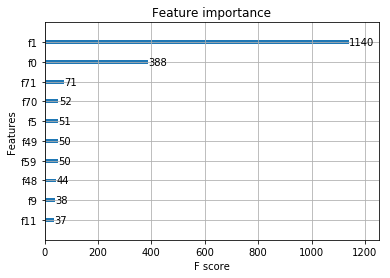

In [25]:
plot_importance(xgb, max_num_features=10)
print(accuracy_score(y_valid, xgb.predict(X_valid)))
print(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]))

In [26]:
%%time
searcher = GridSearchCV(xgb,
                   {'max_depth': [4,5,6],
                    'min_child_weight': [4,5,6]}, verbose=1, n_jobs=1, scoring='roc_auc', cv=3)
searcher.fit(X_train, y_train)
print(searcher.best_score_)
print(searcher.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.8min finished


0.7340508020523824
{'max_depth': 6, 'min_child_weight': 6}
CPU times: user 7min 52s, sys: 3.07 s, total: 7min 55s
Wall time: 4min 5s


In [80]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=500,
                    max_depth=6,
                    min_child_weight=6,
                    n_jobs=-1,
                    seed=17,
                    silent = True)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=6, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=17, silent=True, subsample=1)

0.8258666666666666
0.7699224073506192


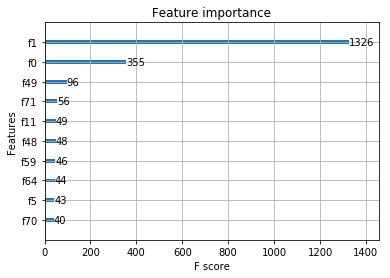

In [81]:
plot_importance(xbg, max_num_features=10)
print(accuracy_score(y_valid, xgb.predict(X_valid)))
print(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]))

In [20]:
xgb = XGBClassifier(learning_rate=0.01,
                    n_estimators=5000,
                    max_depth=6,
                    min_child_weight=6,
                    n_jobs=-1,
                    seed=17,
                    silent = True)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=6, min_child_weight=6, missing=None, n_estimators=5000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=17, silent=True, subsample=1)

0.8255666666666667
0.7661543572714705
0.7335244065148405


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min finished


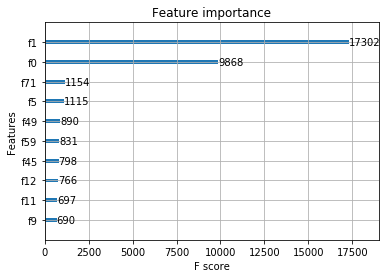

In [19]:
plot_importance(xgb, max_num_features=10)
print(accuracy_score(y_valid, xgb.predict(X_valid)))
print(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:, 1]))
print(np.mean(cross_val_score(xgb, X_train, y_train, verbose=1, n_jobs=1, scoring='roc_auc', cv=3)))

In [21]:
xgb_test_pred = xgb.predict_proba(X_test)[:, 1]
pd.Series(xgb_test_pred, name='dep_delayed_15min').to_csv('xgb.csv', index_label='id', header=True)